In [6]:
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import boto3

In [7]:
## set-up for AWS
'''
Note:
This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance
'''
s3_client = boto3.client('s3')  
bucket_name = 'ca-climate-index'  
directory = '2b_reproject/natural_systems/agricultural_productivity_conservation/usda_nasa'

In [8]:
# open evaporative stress data through xarray
evap_stress = xr.open_dataset('evaporative_stress_index_12week_2015-2022.nc')
evap_stress

<xarray.Dataset>
Dimensions:    (latitude: 199, time: 418, longitude: 220)
Coordinates:
  * latitude   (latitude) float64 32.17 32.22 32.27 32.32 ... 41.97 42.02 42.07
  * time       (time) datetime64[ns] 2015-01-01 2015-01-08 ... 2022-12-25
  * longitude  (longitude) float64 -124.9 -124.8 -124.8 ... -114.0 -114.0 -113.9
Data variables:
    esi        (time, latitude, longitude) float32 ...

In [9]:
# establish working range for parameters outlined in the xarray
lat_min = evap_stress['latitude'].min()
lat_max = evap_stress['latitude'].max()
lon_min = evap_stress['longitude'].min()
lon_max = evap_stress['longitude'].max()

evaporative_stress_analysis = evap_stress['esi'].sel(  
                      latitude=slice(lat_min, lat_max),  
                      longitude=slice(lon_min, lon_max),  
                      )

lat_range = lat_max - lat_min
lon_range = lon_max - lon_min


In [10]:
evaporative_stress_analysis

<xarray.DataArray 'esi' (time: 418, latitude: 199, longitude: 220)>
[18300040 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 32.17 32.22 32.27 32.32 ... 41.97 42.02 42.07
  * time       (time) datetime64[ns] 2015-01-01 2015-01-08 ... 2022-12-25
  * longitude  (longitude) float64 -124.9 -124.8 -124.8 ... -114.0 -114.0 -113.9
Attributes:
    long_name:           evaporative_stress_index
    units:               unitless
    composite_interval:  12 week
    comment:             12-week mean composite estimate of evaporative stres...
    cell_methods:        time: mean

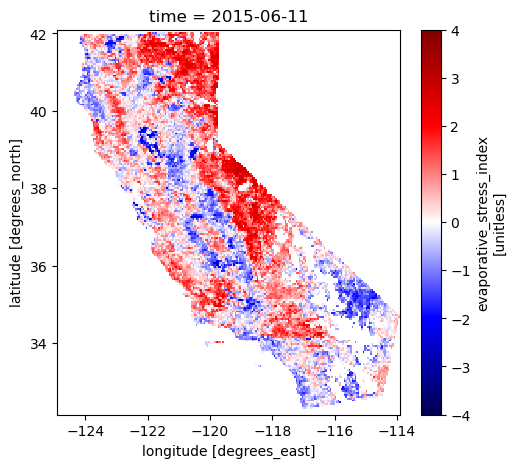

In [11]:
# visualize the evaporative stress for the first date within the data
evaporative_stress_analysis.isel(time=23).plot.imshow(vmin=-4., vmax=4., cmap='seismic', aspect=lon_range/lat_range, size=5)

In [12]:
# load the census tracts spatial data for California
ca_boundaries = gpd.read_file('ca_tract_tiger')

# check the current coordinate system of the census tracts data
print("Original CRS of Census Tracts Data:")
print(ca_boundaries.crs)

Original CRS of Census Tracts Data:
EPSG:4269


In [13]:
# reproject evaporative stress data to the same coordinate system as census tract
evap_stress_repoj = evaporative_stress_analysis.rio.set_crs('EPSG:4269')

In [14]:
# ensure data shape is carried over after reproject
evap_stress_repoj.values.shape

(418, 199, 220)

In [15]:
# clip the reprojected evaporative stress data to California specific census parameter
evap_stress_repoj.rio.clip(geometries=ca_boundaries.geometry)

<xarray.DataArray 'esi' (time: 418, latitude: 189, longitude: 207)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude     (latitude) float64 32.57 32.62 32.67 ... 41.88 41.92 41.97
  * time         (time) datetime64[ns] 2015-01-01 2015-01-08 ... 2022-12-25
  * longitude    (longitude) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2
    spatial_ref  int32 0
Attributes:
    long_name:           evaporative_stress_index
    units:               unitless
    composite_interval:  12 week
    comment:             12-week mean composite estimate of evaporative stres...
    cell_methods:        time: mean

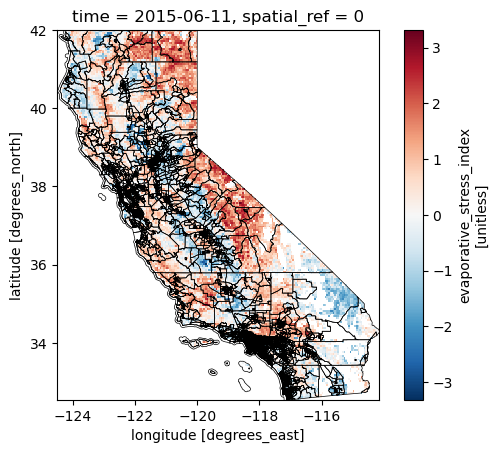

In [16]:
visualize_ca_evap_stress = evap_stress_repoj.rio.clip(geometries=ca_boundaries.geometry).isel(time=23)
fig, ax = plt.subplots()
visualize_ca_evap_stress.plot(ax=ax)

# Plot the shapefile on top of the xarray plot
ca_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# Show the plot
plt.show()

In [21]:
# save newly projected data as a netcdf file
evap_stress_repoj.to_netcdf('evaporative_stress_ca_reproject.nc')

In [22]:
# upload to aws bucket
with open('evaporative_stress_ca_reproject.nc', 'rb') as data:
        s3_client.upload_fileobj(data, bucket_name, f"{directory}/{'evaporative_stress_ca_reproject.nc'}")
        print(f"Merged and sorted files written to: evaporative_stress_ca_reproject.nc")

Merged and sorted files written to: evaporative_stress_ca_reproject.nc


In [24]:
# Close the NetCDF file
evap_stress.close()